## Machine Learning - Lab 03 - Logistic Regression 
* Full name: Đinh Anh Huy
* Student ID: 18110103

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
def sigmoid(x):
  return 1/(1+np.exp((-1)*x))

def softmax(x):
  return np.exp(x) / np.sum(np.exp(x),axis=1).reshape(-1,1)

class Logistic_Regression:
  def __init__(self, learning_rate=0.01, max_iters=1000, random_state=0, batch_size=None, activation_function = None):
    self.W = None
    self.batch_size = batch_size
    self.random_state = random_state
    self.lr = learning_rate
    self.max_iters = max_iters
    self.loss_values = []
    self.weights = []
    self.function = activation_function

  def init_W(self, X, y):
    np.random.seed(self.random_state)
    no_labels = np.unique(y).size
    if no_labels <= 2:
      self.W = np.random.randn(X.shape[1]+1, 1)
    else:
      self.W = np.random.randn(X.shape[1]+1, no_labels)
  
  def init_function(self, y):
    if self.function == None: 
      if np.unique(y).size == 2:
        self.function = "sigmoid"
      else:
        self.function = "softmax"

  def gradient(self, X, y, prediction):
    if self.function == "sigmoid":
      return np.mean((prediction - y)*X, axis=0).reshape(-1,1)
    else:
      a = prediction - y
      gradient = np.zeros([X.shape[1],y.shape[1]])
      for i in range(y.shape[1]):
        gradient[:,i:i+1] = np.mean(a[:,i:i+1]*X, axis=0).reshape(-1,1)
      return gradient

  def updateWeights(self, theta_old, gradient, learning_rate):
    return theta_old - learning_rate*gradient

  def computeLoss(self, X, y, prediction):
    if self.function == "sigmoid":
      return -np.mean((y*np.log(prediction) + (1-y)*np.log(1-prediction)), axis=0)
    else:
      for i in range(y.shape[1]):
        error = (-1*y) * np.log(prediction)
        error = np.sum(np.mean(error, axis=0))
      return error

  def prediction(self, X):
    Z = X.dot(self.W)
    if self.function == "sigmoid":
      return sigmoid(Z)
    return softmax(Z)

  def BGD(self, X, y):
    for epoch in range(self.max_iters):
      pred = self.prediction(X)
      grad = self.gradient(X, y, pred)
      self.W = self.updateWeights(self.W, grad, self.lr)

      self.weights.append(self.W)
      self.loss_values.append(self.computeLoss(X, y, pred))

  def SGD(self, X, y):
    for epoch in range(self.max_iters//X.shape[0]):
      rd_id = np.random.permutation(X.shape[0])
      for i in rd_id:
        X_batch = X[j,:].reshape(1,-1)
        y_batch = y[j,:].reshape(1,-1)
        pred = self.prediction(X_batch)
        grad = self.gradient(X_batch, y_batch, pred)
        self.W = self.updateWeights(self.W, grad, self.lr)
      self.weights.append(self.W)
      self.loss_values.append(self.computeLoss(X, y, self.prediction(X)))        
  
  def Mini_BGD(self, X, y, batch_size):
    first_X = X.copy()
    first_y = y.copy()
    for epoch in range(self.max_iters//(X.shape[0]//self.batch_size + 1)):
      indices = np.random.permutation(X.shape[0])
      first_X = first_X[indices]
      first_y = first_y[indices]

      temp = batch_size
      for j in range(0, X.shape[0], batch_size):    
        X_batch = first_X[j:temp, :]
        y_batch = first_y[j:temp,:]
        pred = self.prediction(X_batch)
        grad = self.gradient(X_batch, y_batch, pred)
        self.W = self.updateWeights(self.W, grad, self.lr)

        temp = temp + batch_size if X.shape[0]-temp >= batch_size else X.shape[0]
      self.weights.append(self.W)
      self.loss_values.append(self.computeLoss(X, y, self.prediction(X)))
    
  def fit(self, X, y):
    self.loss_values.clear()
    self.weights.clear()
    self.init_W(X, y)
    self.init_function(y)

    X1 = np.concatenate([np.ones([X.shape[0],1]), X], axis=1)
    if self.function == "softmax":
      y = onehot_encoder(y)
    else:
      y = y.reshape(-1, 1)
    

    if (self.batch_size == None) or (self.batch_size == X.shape[0]):
      self.BGD(X1, y)
    elif (self.batch_size > 1) and (self.batch_size < X.shape[0]):
      self.Mini_BGD(X1, y, self.batch_size)
    elif self.batch_size == 1:
      self.SGD(X1, y)
    else:
      raise Exception("Batch size is impossible.")

  def predict(self, X):
    X1 = np.concatenate([np.ones([X.shape[0],1]), X], axis=1)
    Z = X1.dot(self.W)
    if self.function == "sigmoid":
      prediction = sigmoid(Z)
      return np.where(prediction>0.5,1,0).reshape(1,-1)
    else:
      prediction = softmax(Z)
      return np.argmax(prediction,axis=1)
      

  def coef_(self):
    return self.W[1:,:]

  def intercept_(self):
    return self.W[1,:]

  def score(self, X, y):
    if self.function == "sigmoid":
      y = y.reshape(1,-1).T
    return np.mean(y==self.predict(X).T)

In [3]:
def scaler(X_train, X_test):
  max = np.max(X_train,axis=0)
  min = np.min(X_train,axis=0)

  X_train = (X_train-min)/(max-min)
  X_test = (X_test-min)/(max-min)
  return X_train, X_test

def onehot_encoder(y):
  y_onehot = np.zeros( (y.size, y.max() + 1), dtype=int)
  y_onehot[np.arange(y.size), y.reshape(-1)] = 1
  return y_onehot

### Bài tập 1. Hãy xây dựng mô hình logistic regression bằng tất cả các features trong file heart, so sánh với thư viện sklearn.

In [4]:
# Load data
data = pd.read_csv("https://raw.githubusercontent.com/huynhthanh98/ML/master/lab-03/heart.csv")
data.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [5]:
# Split data, 33% for test and 67% for train
X = data.drop(['target'], axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.33, random_state=42)

# Scale data using min-max method
X_train, X_test = scaler(X_train, X_test)

In [6]:
lr = Logistic_Regression(learning_rate=0.1, max_iters=30000, random_state=10)
lr.fit(X_train, y_train)
for i in range(0, len(lr.loss_values), 1000):
  print("Loss at iter {}: {}".format(i, lr.loss_values[i]))
print("\n", "-"*40, "\n")
print(">> Final loss: ", lr.loss_values[-1])
print(">> Final W: \n", lr.W)

Loss at iter 0: [0.99859025]
Loss at iter 1000: [0.34206429]
Loss at iter 2000: [0.32313667]
Loss at iter 3000: [0.31577836]
Loss at iter 4000: [0.31207608]
Loss at iter 5000: [0.31000355]
Loss at iter 6000: [0.30877428]
Loss at iter 7000: [0.30801748]
Loss at iter 8000: [0.30753881]
Loss at iter 9000: [0.30722959]
Loss at iter 10000: [0.3070263]
Loss at iter 11000: [0.30689058]
Loss at iter 12000: [0.30679871]
Loss at iter 13000: [0.30673572]
Loss at iter 14000: [0.306692]
Loss at iter 15000: [0.30666127]
Loss at iter 16000: [0.30663943]
Loss at iter 17000: [0.30662371]
Loss at iter 18000: [0.30661226]
Loss at iter 19000: [0.30660382]
Loss at iter 20000: [0.30659753]
Loss at iter 21000: [0.30659278]
Loss at iter 22000: [0.30658917]
Loss at iter 23000: [0.30658638]
Loss at iter 24000: [0.30658421]
Loss at iter 25000: [0.30658251]
Loss at iter 26000: [0.30658116]
Loss at iter 27000: [0.30658008]
Loss at iter 28000: [0.30657922]
Loss at iter 29000: [0.30657852]

 ------------------------

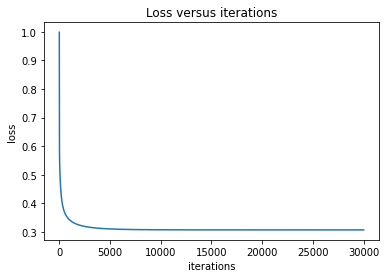

In [7]:
# Plot loss versus interations
fig, ax = plt.subplots()

ax.plot(lr.loss_values)
ax.set_title('Loss versus iterations')
ax.set(xlabel='iterations', ylabel='loss')

plt.show()

In [8]:
print(">> Original label: \n", y_test)
y_pred = lr.predict(X_test)
print("\n>> Predicted label: \n", y_pred.flatten())
print("\n>> Score: ", lr.score(X_test, y_test))

>> Original label: 
 [0 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1
 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0]

>> Predicted label: 
 [0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1
 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0]

>> Score:  0.81


In [9]:
print(">> Accuracy score: ", accuracy_score(y_test, y_pred.flatten()))

>> Accuracy score:  0.81


**Kết quả bài toán Logistic Regression với bộ dữ liệu *Heart* chạy bằng thư viện scikit-learn**

In [10]:
lr_sklearn = LogisticRegression(random_state=10)
lr_sklearn.fit(X_train, y_train)

y_pred_sklearn = lr_sklearn.predict(X_test)
score_sklearn = lr_sklearn.score(X_test, y_test)

print(">> Original label: \n", y_test)
print("\n>> Predicted label: \n", y_pred_sklearn.flatten())
print("\n>> Score: ", score_sklearn)

>> Original label: 
 [0 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1
 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0]

>> Predicted label: 
 [0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1
 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0]

>> Score:  0.81


In [11]:
print(">> Accuracy score: ", accuracy_score(y_test, y_pred_sklearn))

>> Accuracy score:  0.81


### Bài tập 2. Hãy xây dựng mô hình softmax regression trên bộ Iris (nên Normalize data), so sánh với thư viện sklearn.

In [12]:
from sklearn.datasets import load_iris

iris_data = load_iris()
X = iris_data.data
y = iris_data.target

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.33, random_state=57)
X_train2, X_test2 = scaler(X_train2, X_test2)

y_test_enc = onehot_encoder(y_test2)

In [13]:
lr2 = Logistic_Regression(learning_rate=0.01, max_iters=50000, random_state=0)
lr2.fit(X_train2, y_train2)
for i in range(0, len(lr2.loss_values), 2000):
  print("Loss at iter {}: {}".format(i, lr2.loss_values[i]))
print("\n", "-"*40, "\n")
print(">> Final loss: ", lr2.loss_values[-1])
print(">> Final W: \n", lr2.W)

Loss at iter 0: 1.9360183233931814
Loss at iter 2000: 0.6313735604835801
Loss at iter 4000: 0.5058452273146778
Loss at iter 6000: 0.43961337025442104
Loss at iter 8000: 0.3965167423272834
Loss at iter 10000: 0.3653566373455009
Loss at iter 12000: 0.341316064203433
Loss at iter 14000: 0.3219258931905534
Loss at iter 16000: 0.30577505777449804
Loss at iter 18000: 0.29199347744864257
Loss at iter 20000: 0.28001285438184487
Loss at iter 22000: 0.2694445511483064
Loss at iter 24000: 0.2600125240292316
Loss at iter 26000: 0.25151432985447264
Loss at iter 28000: 0.24379737828480139
Loss at iter 30000: 0.23674389576466337
Loss at iter 32000: 0.23026108332878803
Loss at iter 34000: 0.22427448491044266
Loss at iter 36000: 0.218723403289788
Loss at iter 38000: 0.2135576584238891
Loss at iter 40000: 0.20873524756489212
Loss at iter 42000: 0.20422062459711524
Loss at iter 44000: 0.1999834130698303
Loss at iter 46000: 0.1959974285174081
Loss at iter 48000: 0.19223992502560122

 ---------------------

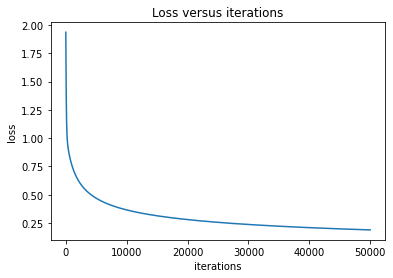

In [14]:
fig, ax = plt.subplots()

ax.plot(lr2.loss_values)
ax.set_title('Loss versus iterations')
ax.set(xlabel='iterations', ylabel='loss')

plt.show()

In [15]:
print(">> Original label: \n", y_test2)
y_pred2 = lr2.predict(X_test2)
print("\n>> Predicted label: \n", y_pred2)
print("\n>> Score: ", lr2.score(X_test2, y_test2))

>> Original label: 
 [2 2 1 1 0 1 0 2 1 0 1 0 0 0 1 2 1 0 0 2 2 0 2 2 2 0 2 2 2 2 0 2 0 0 1 2 0
 1 1 2 1 0 2 0 0 0 1 0 2 2]

>> Predicted label: 
 [2 1 1 1 0 1 0 2 1 0 1 0 0 0 1 2 1 0 0 2 2 0 2 2 2 0 2 2 2 2 0 2 0 0 1 2 0
 1 1 2 1 0 2 0 0 0 1 0 2 2]

>> Score:  0.98


In [16]:
print(">> Accuracy score: ", accuracy_score(y_test2, y_pred2.flatten()))

>> Accuracy score:  0.98


**Kết quả bài toán Logistic Regression với bộ dữ liệu *Iris* chạy bằng thư viện scikit-learn**

In [17]:
lr2_sklearn = LogisticRegression()
lr2_sklearn.fit(X_train2, y_train2)

y_pred2_sklearn = lr2_sklearn.predict(X_test2)
score2_sklearn = lr2_sklearn.score(X_test2, y_test2)

print(">> Original label: \n", y_test2)
print("\n>> Predicted label: \n", y_pred2_sklearn)
print("\n>> Score: ", score2_sklearn)

>> Original label: 
 [2 2 1 1 0 1 0 2 1 0 1 0 0 0 1 2 1 0 0 2 2 0 2 2 2 0 2 2 2 2 0 2 0 0 1 2 0
 1 1 2 1 0 2 0 0 0 1 0 2 2]

>> Predicted label: 
 [2 1 1 1 0 1 0 2 1 0 1 0 0 0 1 2 1 0 0 2 2 0 2 2 2 0 2 2 2 2 0 2 0 0 1 2 0
 1 1 2 1 0 2 0 0 0 1 0 2 2]

>> Score:  0.98


In [18]:
print(">> Accuracy score: ", accuracy_score(y_test2, y_pred2_sklearn))

>> Accuracy score:  0.98
